## Import the required libraries

In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

## Import the Dataset

In [2]:
dataset = pd.read_csv('data/bank_churn_data.csv')
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data preprocessing

### Segregate the features and labels

In [3]:
dataset.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [4]:
unuseful_features = ['RowNumber', 'CustomerId', 'Surname']
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
labels = ['Exited']

### Set the categorical feature-columns

In [5]:
for feature in categorical_features:
    dataset[feature] = dataset[feature].astype('category')

### Convert the categorical feature-columns to tensors
* Convert the categorical columns to their code-values array
* Convert the array to a tensor
* Apply *torch.int64* as the data type for categorical columns

In [6]:
geo = dataset['Geography'].cat.codes.values
gen = dataset['Gender'].cat.codes.values
hcc = dataset['HasCrCard'].cat.codes.values
iam = dataset['IsActiveMember'].cat.codes.values

categorical_data = np.stack([geo, gen, hcc, iam], 1)

categorical_tensors = torch.tensor(categorical_data, dtype=torch.int64)
print(categorical_tensors.shape)

torch.Size([10000, 4])


### Convert the numerical feature-columns to tensors
* Convert the numerical columns to their values array
* Convert the array to a tensor
* Apply *torch.float* as the data type for numerical feature-columns

In [7]:
numerical_data = np.stack([dataset[col].values for col in numerical_features], 1)

numerical_tensors = torch.tensor(numerical_data, dtype=torch.float)
print(numerical_tensors.shape)

torch.Size([10000, 6])


### Convert the label-column to tensor
* Obtain the label-column values
* Convert them to a tensor
* Flatten the same

In [8]:
label_data = dataset[labels].values

label_tensor = torch.tensor(label_data).flatten()
print(label_tensor.shape)

torch.Size([10000])


## Split data into Training and Test sets
* Training data = 80% of total records
* Test data = 20% of total records

In [9]:
total = dataset.shape[0]
test = int(total*.2)

categorical_tensors_trn = categorical_tensors[:total-test]
print('categorical train data:', len(categorical_tensors_trn))
numerical_tensors_trn = numerical_tensors[:total-test]
print('numerical train data:', len(numerical_tensors_trn))
label_tensor_trn = label_tensor[:total-test]
print('train outputs', len(label_tensor_trn))

categorical_tensors_tst = categorical_tensors[total-test:total]
print('categorical test data:', len(categorical_tensors_tst))
numerical_tensors_tst = numerical_tensors[total-test:total]
print('numerical test data:', len(numerical_tensors_tst))
label_tensor_tst = label_tensor[total-test:total]
print('test outputs', len(label_tensor_tst))

categorical train data: 8000
numerical train data: 8000
train outputs 8000
categorical test data: 2000
numerical test data: 2000
test outputs 2000


## Create the model 

### Prepare size for the *Embedding* layer
* Divide the no. of unique values in the column by 2 but <= 50

In [10]:
cat_col_sizes = [len(dataset[f].cat.categories) for f in categorical_features]
cat_emb_sizes = [(size, min(50, (size+1)//2)) for size in cat_col_sizes]
print('Categorical Embedding sizes:', cat_emb_sizes)

Categorical Embedding sizes: [(3, 2), (2, 1), (2, 1), (2, 1)]


### Define the model
* The Model class inherits from ***PyTorch***'s **nn** module's ***Module*** class.
* Initializing:
    * Required Parameters
      * **embedding_size**: contains the list of embedding size for the categorical columns
      * **num_cols**: total number of numerical columns
      * **output_size**: number of possible outputs
      * **layers**: list of no. of neurons for all the layers
      * **p**: Dropout (default=0.5)
    * Initialized variables
      * **all_embeddings**: list of ***ModuleList*** objects for the embedding sizes of the categorical columns
      * **embedding_dropout**: ***Dropout*** value for all the layers
      * **batch_norm_num**: list of ***BatchNorm1d*** objects for all the numerical columns
      * **input_size**: size of the input layer; total number of numerical and categorical layers
    * Model layers
      * ***Linear***: to calculate dot product of input layer and weight matrices
      * ***ReLU***: applied as the activation function
      * ***BatchNorm1d***: to apply batch normalization to the numerical columns
      * ***Dropout***: to avoid overfitting
      * ***Linear***: for the output layer
    * All the layers set to exectute sequentially using ***Sequential*** class
* Passing the embedded categorical and numberical features as inputs to the model
  * Obtain the embedded categorical columns
  * Add the embedded categorical columns to embedded layer
  * Dropout to prevent overfitting
  * Normalize the embedded numerical columns
  * Add the embedded numerical columns to embedded layer
  * Pass the embedded layer to the sequential layers

In [11]:
class Model(nn.Module):
    
    def __init__(self, embedding_size, num_cols, output_size, layers, p=0.5):
        super().__init__()
        
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in embedding_size])
        
        self.embedding_dropout = nn.Dropout(p)
        
        self.batch_norm_num = nn.BatchNorm1d(num_cols)
        
        input_size = num_cols + sum((nf for ni,nf in embedding_size))
        
        all_layers = []
        for n in layers:
            all_layers.append(nn.Linear(input_size, n))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(n))
            all_layers.append(nn.Dropout(p))
            input_size = n
        all_layers.append(nn.Linear(layers[-1], output_size))
        
        self.layers = nn.Sequential(*all_layers)
        
    def forward(self, cat_emb, num_emb):
        
        cat_embeddings = []
        for i,e in enumerate(self.all_embeddings):
            cat_embeddings.append(e(cat_emb[:,i]))
        
        emb = torch.cat(cat_embeddings, 1)
        
        emb = self.embedding_dropout(emb)
        
        num_embeddings = self.batch_norm_num(num_emb)
        
        emb = torch.cat([emb, num_embeddings], 1)
        
        emb = self.layers(emb)
        
        return emb

### Set the model 
Pass the following parameter values:
* embedding size of the categorical columns
* the number of numerical columns
* the number of outputs (2, for exited or not exited)
* the list of neurons for the hidden layers (3: 200, 100, 50)
* the dropout value (0.4, default=0.5)

In [12]:
model = Model(
    embedding_size = cat_emb_sizes,
    num_cols = numerical_tensors.shape[1],
    output_size = 2,
    layers = [200, 100, 50],
    p = 0.4
)

print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(2, 1)
    (2): Embedding(2, 1)
    (3): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_featu

## Train the model
* Define the loss function
* Define the optimizer function
* Set the number of epochs
* Iterate till the number of epochs to train the model
  * Pass the embedded training data to the model and predict the label
  * Calculate the loss using the loss function
  * Save the loss to the aggregated loss list
  * Set gradient to zero
  * Update the weights based on the loss
  * Update the gradient

In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 300

aggregated_losses = []
for i in range(epochs):
    i += 1
    pred = model(categorical_tensors_trn, numerical_tensors_trn)
    loss = loss_function(pred, label_tensor_trn)
    aggregated_losses.append(loss) 
    if i%20 == 1: #print loss after every 20 epochs
        print(f'epoch: {i:3} loss: {loss.item():10.5f}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(f'epoch: {i:3} loss: {loss.item():10.5f}')

epoch:   1 loss:    0.78524
epoch:  21 loss:    0.60246
epoch:  41 loss:    0.54884
epoch:  61 loss:    0.50174
epoch:  81 loss:    0.45219
epoch: 101 loss:    0.42238
epoch: 121 loss:    0.39483
epoch: 141 loss:    0.38669
epoch: 161 loss:    0.38241
epoch: 181 loss:    0.38472
epoch: 201 loss:    0.36969
epoch: 221 loss:    0.37332
epoch: 241 loss:    0.36577
epoch: 261 loss:    0.36432
epoch: 281 loss:    0.36342
epoch: 300 loss:    0.35960


### Plot the losses

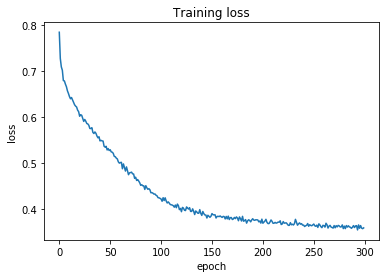

In [15]:
plt.figure()
plt.plot(range(epochs), aggregated_losses)
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Test the model

In [16]:
with torch.no_grad():
    val = model(categorical_tensors_tst, numerical_tensors_tst)
    loss = loss_function(val, label_tensor_tst)
print(f'loss: {loss:.5f}')

loss: 0.36882


## Make predictions
* Check predictions for the first five test values
* Predictions are a list
  * Higher value in the first index implies output is 0
  * Higher value in the second index implies output is 1
* Retrieve the index of the larger value in the list

In [18]:
print(val[:5])
val = np.argmax(val, axis=1)
print(val[:5])

tensor([[ 0.5004, -1.1256],
        [ 2.5681, -1.3775],
        [ 1.2293, -2.1442],
        [ 0.1821, -0.2792],
        [ 1.6485, -1.5388]])
tensor([0, 0, 0, 0, 0])


## Evaluate the model
* Classification report
* Confusion matrix
* Accuracy score

In [25]:
print('Classification Report')
print(classification_report(label_tensor_tst, val))

print('Confusion Matrix')
print(confusion_matrix(label_tensor_tst, val))

print('\nAccuracy Score:',accuracy_score(label_tensor_tst, val)*100,'%')

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1610
           1       0.64      0.41      0.50       390

    accuracy                           0.84      2000
   macro avg       0.76      0.68      0.70      2000
weighted avg       0.83      0.84      0.83      2000

Confusion Matrix
[[1521   89]
 [ 229  161]]

Accuracy Score: 84.1 %


## Save the model

In [27]:
pickle.dump(model, open('model.sav', 'wb'))